In [ ]:
print("Start")

Start


##Import modules

In [ ]:
import numpy as np
import pandas as pd
import re
import os
import string
import matplotlib.pyplot as plt
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
! pip install -q scikit-plot
import scikitplot as skplt

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


##Load data

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Medical Speech, Transcription, and Intent/data/overview-of-recordings.csv')
df.head()

,audio_clipping,audio_clipping:confidence,background_noise_audible,background_noise_audible:confidence,overall_quality_of_the_audio,quiet_speaker,quiet_speaker:confidence,speaker_id,file_download,file_name,phrase,prompt,writer_id
0,no_clipping,1.0000,light_noise,1.0000,3.33,audible_speaker,1.0,43453425,https://ml.sandbox.cf3.us/cgi-bin/index.cgi?do...,1249120_43453425_58166571.wav,When I remember her I feel down,Emotional pain,21665495
1,light_clipping,0.6803,no_noise,0.6803,3.33,audible_speaker,1.0,43719934,https://ml.sandbox.cf3.us/cgi-bin/index.cgi?do...,1249120_43719934_43347848.wav,When I carry heavy things I feel like breaking...,Hair falling out,44088126
2,no_clipping,1.0000,no_noise,0.6655,3.33,audible_speaker,1.0,43719934,https://ml.sandbox.cf3.us/cgi-bin/index.cgi?do...,1249120_43719934_53187202.wav,there is too much pain when i move my arm,Heart hurts,44292353
3,no_clipping,1.0000,light_noise,1.0000,3.33,audible_speaker,1.0,31349958,https://ml.sandbox.cf3.us/cgi-bin/index.cgi?do...,1249120_31349958_55816195.wav,My son had his lip pierced and it is swollen a...,Infected wound,43755034
4,no_clipping,1.0000,no_noise,1.0000,4.67,audible_speaker,1.0,43719934,https://ml.sandbox.cf3.us/cgi-bin/index.cgi?do...,1249120_43719934_82524191.wav,My muscles in my lower back are aching,Infected wound,21665495


In [ ]:
df.shape

(6661, 13)

In [ ]:
df.columns

Index(['audio_clipping', 'audio_clipping:confidence',
       'background_noise_audible', 'background_noise_audible:confidence',
       'overall_quality_of_the_audio', 'quiet_speaker',
       'quiet_speaker:confidence', 'speaker_id', 'file_download', 'file_name',
       'phrase', 'prompt', 'writer_id'],
      dtype='object')

In [ ]:
df = df[["overall_quality_of_the_audio", "phrase", "prompt"]]
df.head()

,overall_quality_of_the_audio,phrase,prompt
0,3.33,When I remember her I feel down,Emotional pain
1,3.33,When I carry heavy things I feel like breaking...,Hair falling out
2,3.33,there is too much pain when i move my arm,Heart hurts
3,3.33,My son had his lip pierced and it is swollen a...,Infected wound
4,4.67,My muscles in my lower back are aching,Infected wound


In [ ]:
df.isnull().sum()

overall_quality_of_the_audio    0
phrase                          0
prompt                          0
dtype: int64

In [ ]:
df["overall_quality_of_the_audio"].describe()

count    6661.000000
mean        3.678268
std         0.378536
min         3.000000
25%         3.330000
50%         3.670000
75%         4.000000
max         5.000000
Name: overall_quality_of_the_audio, dtype: float64

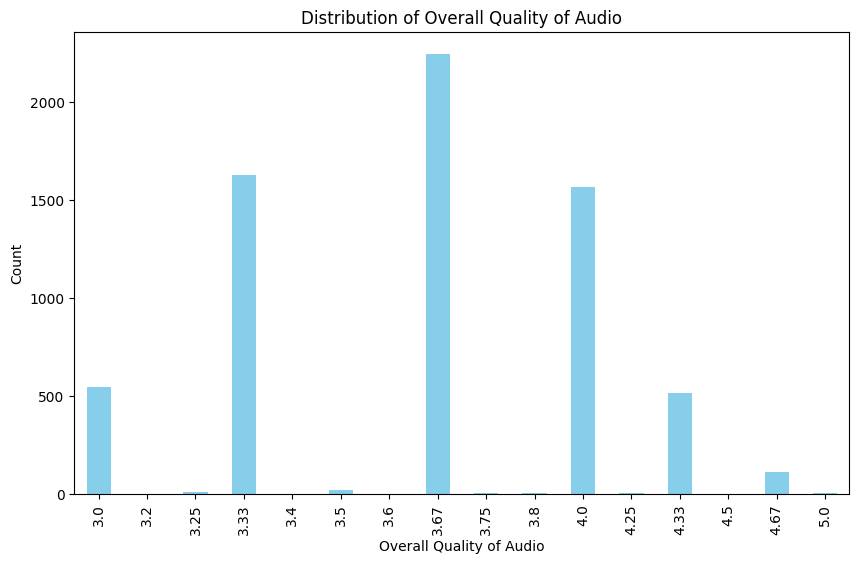

In [ ]:
value_counts = df["overall_quality_of_the_audio"].value_counts().sort_index()

plt.figure(figsize=(10, 6))
value_counts.plot(kind='bar', color='skyblue')
plt.title('Distribution of Overall Quality of Audio')
plt.xlabel('Overall Quality of Audio')
plt.ylabel('Count')
plt.show()

In [ ]:
df = df[["phrase", "prompt"]]
x = df["phrase"]
y = df["prompt"]

In [ ]:
print("Different numbers of Symptoms(labels):", y.nunique())

Different numbers of Symptoms(labels): 25


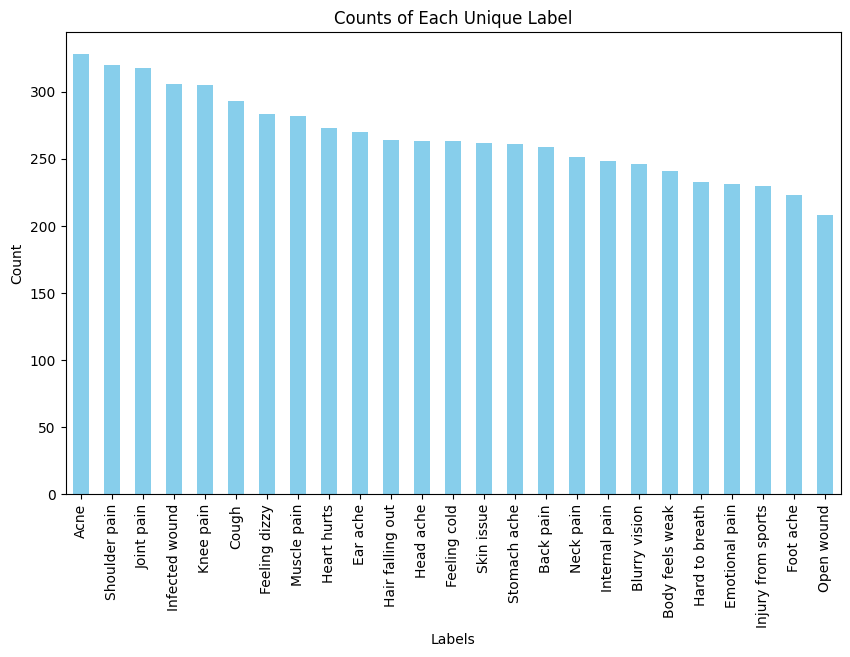

In [ ]:
label_counts = y.value_counts()

plt.figure(figsize=(10, 6))
label_counts.plot(kind='bar', color='skyblue')
plt.title('Counts of Each Unique Label')
plt.xlabel('Labels')
plt.ylabel('Count')
plt.show()

In [ ]:
word_count = [len(sent.split(' ')) for sent in x]
word_count = pd.Series(word_count)
word_count.describe()

count    6661.000000
mean       10.592253
std         4.866114
min         2.000000
25%         7.000000
50%        10.000000
75%        13.000000
max        30.000000
dtype: float64

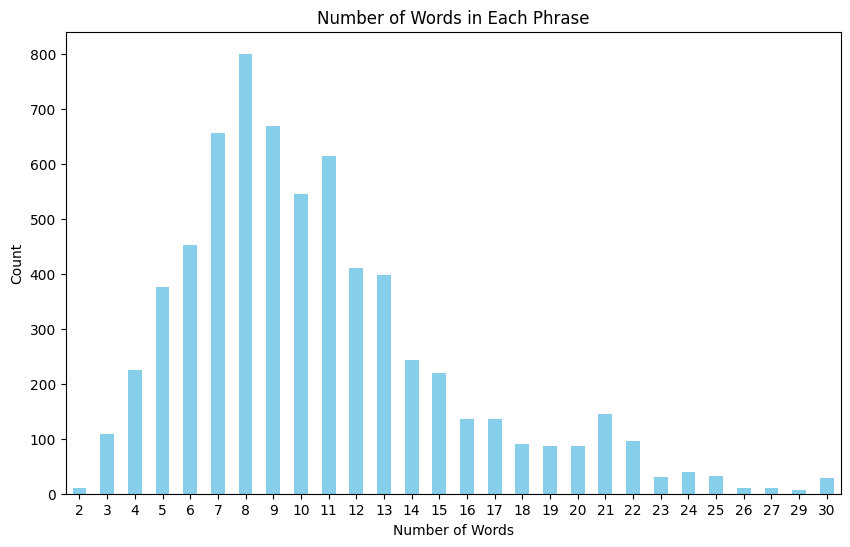

In [ ]:
plt.figure(figsize=(10, 6))
word_count.value_counts().sort_index().plot(kind='bar', color='skyblue')
plt.title('Number of Words in Each Phrase')
plt.xlabel('Number of Words')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

##Preprocess

In [ ]:
def clean_data(doc):
  #lowering
  doc = doc.lower()
  #remove URL
  url = r"http\S+|https\S+|www\S+"
  doc = re.sub(url, '', doc)
  #remove punctuation
  punct = ".,:;'\"()[]{}!@#$%^&*-_=+?<>`~"
  strng = [chr for chr in doc if chr not in punct]
  doc = ''.join(strng)
  #remove stopwords
  words = doc.split(' ')
  stop_words = set(stopwords.words('english'))
  words = [word for word in words if(word!='' and word not in stop_words)]
  #lemmatization
  lemmatizer = nltk.stem.WordNetLemmatizer()
  words = [lemmatizer.lemmatize(word) for word in words]
  doc = ' '.join(words)
  return doc

In [ ]:
x[2]

'there is too much pain when i move my arm'

In [ ]:
clean_data(x[2])

'much pain move arm'

In [ ]:
x = x.apply(clean_data)

In [ ]:
word_count = [len(sent.split(' ')) for sent in x]
word_count = pd.Series(word_count)
word_count.describe()

count    6661.000000
mean        5.203423
std         2.341150
min         1.000000
25%         3.000000
50%         5.000000
75%         6.000000
max        14.000000
dtype: float64

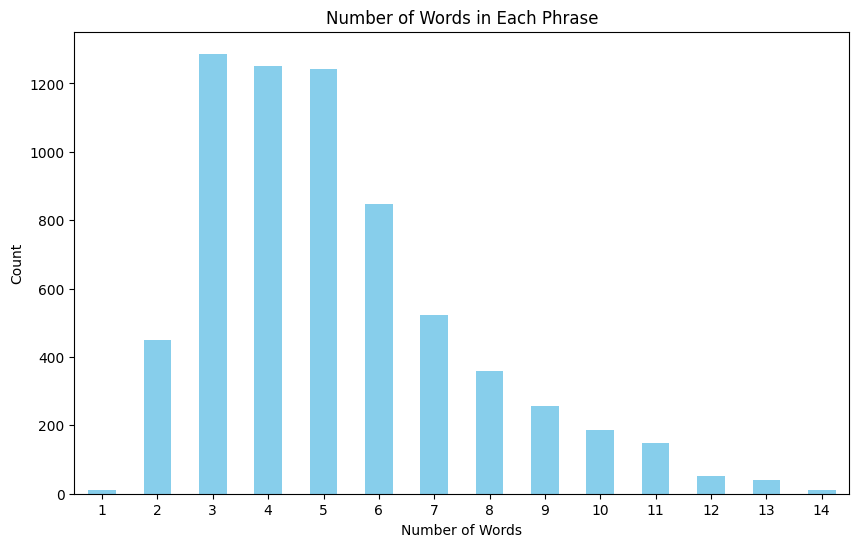

In [ ]:
plt.figure(figsize=(10, 6))
word_count.value_counts().sort_index().plot(kind='bar', color='skyblue')
plt.title('Number of Words in Each Phrase')
plt.xlabel('Number of Words')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

In [ ]:
x.head(5)

0                                        remember feel
1            carry heavy thing feel like breaking back
2                                   much pain move arm
3    son lip pierced swollen skin inside lip grey l...
4                             muscle lower back aching
Name: phrase, dtype: object

In [ ]:
type(x)

pandas.core.series.Series

In [ ]:
type(y)

pandas.core.series.Series

##Model

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, stratify=y, random_state=42)

In [ ]:
vectorizers = {
    'CountVectorizer': CountVectorizer(),
    'TfidfVectorizer': TfidfVectorizer()
}

In [ ]:
models = {
    'DecisionTreeClassifier': DecisionTreeClassifier(random_state=42),
    'RandomForestClassifier': RandomForestClassifier(random_state=42),
    'KNeighborsClassifier': KNeighborsClassifier(),
    'SVC': SVC(),
}

In [ ]:
k_folds = 5
kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)

In [ ]:
for vectorizer_name, vectorizer in vectorizers.items():
  x_vect = vectorizer.fit_transform(x)
  x_train, x_test, y_train, y_test = train_test_split(x_vect, y, test_size=0.2, stratify=y, random_state=42)
  for model_name, model in models.items():
    scores = cross_val_score(model, x_vect, y, cv=kf)
    mean_accuracy = scores.mean()
    print(f"Vectorizer:{vectorizer_name}, Model:{model_name} \nAccuracy: {100*mean_accuracy:.4f}")

Vectorizer:CountVectorizer, Model:DecisionTreeClassifier 
Accuracy: 99.6097
Vectorizer:CountVectorizer, Model:RandomForestClassifier 
Accuracy: 99.6247
Vectorizer:CountVectorizer, Model:KNeighborsClassifier 
Accuracy: 99.4145
Vectorizer:CountVectorizer, Model:SVC 
Accuracy: 99.5646
Vectorizer:TfidfVectorizer, Model:DecisionTreeClassifier 
Accuracy: 99.6247
Vectorizer:TfidfVectorizer, Model:RandomForestClassifier 
Accuracy: 99.6247
Vectorizer:TfidfVectorizer, Model:KNeighborsClassifier 
Accuracy: 99.3694
Vectorizer:TfidfVectorizer, Model:SVC 
Accuracy: 99.5797


In [ ]:
model = RandomForestClassifier(random_state=42)
model.fit(x_train, y_train)
y_pred = model.predict(x_test)
test_accuracy = accuracy_score(y_test, y_pred)
print(f"Test accuracy: {100*test_accuracy:.4f}")

Test accuracy: 99.5499


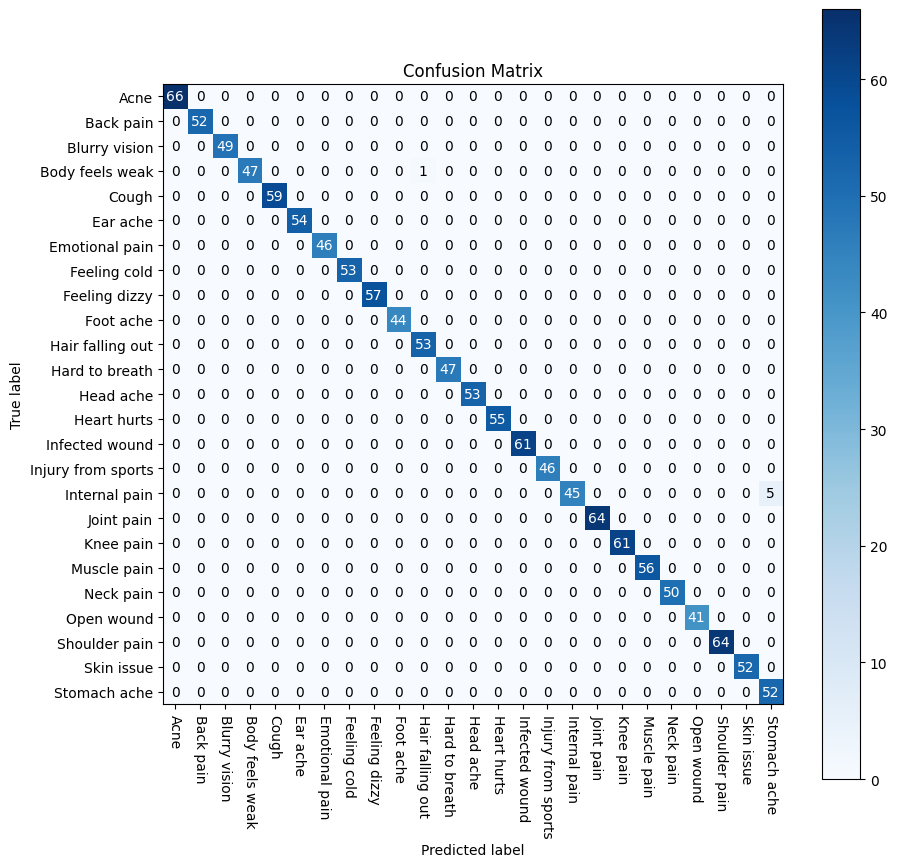

In [ ]:
skplt.metrics.plot_confusion_matrix(y_test, y_pred, figsize=(10,10))

plt.xticks(rotation=270)
plt.show()

In [ ]:
print(classification_report(y_test, y_pred))

                    precision    recall  f1-score   support

              Acne       1.00      1.00      1.00        66
         Back pain       1.00      1.00      1.00        52
     Blurry vision       1.00      1.00      1.00        49
   Body feels weak       1.00      0.98      0.99        48
             Cough       1.00      1.00      1.00        59
          Ear ache       1.00      1.00      1.00        54
    Emotional pain       1.00      1.00      1.00        46
      Feeling cold       1.00      1.00      1.00        53
     Feeling dizzy       1.00      1.00      1.00        57
         Foot ache       1.00      1.00      1.00        44
  Hair falling out       0.98      1.00      0.99        53
    Hard to breath       1.00      1.00      1.00        47
         Head ache       1.00      1.00      1.00        53
       Heart hurts       1.00      1.00      1.00        55
    Infected wound       1.00      1.00      1.00        61
Injury from sports       1.00      1.00